In [69]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")

import io
from pysam import VariantFile

from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve

In [70]:
def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    res = pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})
    return res

foo = lambda x: pd.Series(x.split('CALLERS=')[1].split(';')[0])

In [71]:
context = 'paper' # talk or paper

if context == 'talk':
    sns.set(style="darkgrid", context="talk", rc={"lines.linewidth": 2, "legend.fontsize":25})
    plt.style.use("dark_background")
    plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5,'font.size': 30})
    sns.set_palette("deep")
else:
    sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 1, "legend.fontsize":10})
    plt.rcParams.update({'font.size': 15})
    sns.set_palette("deep")

lc = 'w' if context == 'talk' else 'k'

In [72]:
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
nmethods = len(methods)

In [73]:
tab20 = cm.get_cmap('tab10', 8)
newcmap_list = []
for i in range(4):
    newcmap_list.append(tab20.colors[i])
for i in range(4):
    newcmap_list.append(np.array(list(tab20.colors[i][:-1]) +[0.3]))

newcmap = ListedColormap(newcmap_list, name='newcmap')
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

In [74]:
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875)]
alpha_list = [1, 1, .8, .6, .4, .2, 0.1]

# Select plasma sample and reference

In [75]:
#sample = '809'
sample = '986'
reference = 'pooledhealthy'
#reference = 'lowtb'

In [76]:
if sample == '809':
    plasmasample1 = 'CRC-809_110914'
    plasmasample2 = 'CRC-809_030915'
    tumorsample1 = 'NCC_CRC-809_290714-T1W'
elif sample == '986':
    plasmasample1 = 'CRC-986_100215'
    plasmasample2 = 'CRC-986_261016'
    tumorsample1 = 'NCC_CRC-986_100215-T1W'

In [77]:
if reference == 'lowtb':
    if sample == '986':
        reference = 'CRC-986_300316'
    elif sample == '809':
        raise ValueError('no matched low tb sample')

print(reference) # pooledhealthy if not lowtb

pooledhealthy


# Load SNV calls
## Calls of dilution series

In [101]:
vcf_pd_dict = {}
samples_dict = {}

for i, d in enumerate(dilutionseries):
    print('vcf_pd_'+str(i), d)
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    vcf_path = os.path.join("..","data","bcbio_output", "dilution_chr22_"+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]),
                                                        "dilution_chr22_"+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
    if os.path.exists(vcf_path):
        vcf_pd_dict['vcf_pd_'+str(i)] = read_vcf(vcf_path)

        if i == 0:
            print(vcf_pd_dict['vcf_pd_'+str(i)].head())

        vcf_pd_dict['vcf_pd_'+str(i)]['callers'] = vcf_pd_dict['vcf_pd_'+str(i)]['INFO'].apply(foo)
        vcf_pd_dict['vcf_pd_'+str(i)]['type'] = np.nan
        vcf_pd_dict['vcf_pd_'+str(i)]['type'][vcf_pd_dict['vcf_pd_'+str(i)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(i)]['REF'].str.len() == 0] = 'SNV'
        vcf_pd_dict['vcf_pd_'+str(i)]['type'][vcf_pd_dict['vcf_pd_'+str(i)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(i)]['REF'].str.len() > 0] = 'INS'
        vcf_pd_dict['vcf_pd_'+str(i)]['type'][vcf_pd_dict['vcf_pd_'+str(i)]['ALT'].str.len() - vcf_pd_dict['vcf_pd_'+str(i)]['REF'].str.len() < 0] = 'DEL'
        vcf_pd_dict['vcf_pd_'+str(i)]['type'][vcf_pd_dict['vcf_pd_'+str(i)]['ID'].str.contains('rs')] = 'SNP'
        for m in methods:
            vcf_pd_dict['vcf_pd_'+str(i)][m] = vcf_pd_dict['vcf_pd_'+str(i)]['INFO'].str.contains(m)
            
        sample = vcf_pd_dict['vcf_pd_'+str(i)][['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'type', *methods]]
        sample['CHROM_POS'] = sample['CHROM'].astype('str').str.cat(sample['POS'].astype('str'),sep="_")
        sample.set_index('CHROM_POS', inplace = True)
        sample = sample[sample['CHROM'] == '22']
        samples_dict['sample_'+str(i)] = sample

nsamples = len(vcf_pd_dict.keys())
vcf_pd_dict['vcf_pd_'+str(nsamples-1)].head()

vcf_pd_0 (1, 0)
  CHROM       POS           ID      REF ALT   QUAL FILTER  \
0    22  16060479            .  TTTTTTC   T  133.0   PASS   
1    22  16070779            .        A   T    0.0   PASS   
2    22  16078514    rs4332660        C   T    0.0   PASS   
3    22  16085343  rs944762128        C   T    0.0   PASS   
4    22  16113015   rs12484665        T   C    0.0   PASS   

                                                INFO  \
0  AF=0.1019;CALLERS=vardict;DP=108;LSEQ=CCATGAGC...   
1  CALLERS=varscan;DP=44;GPV=1;SOMATIC;SPV=0.1963...   
2  CALLERS=varscan;DP=20;GPV=1;SOMATIC;SPV=0.3193...   
3  CALLERS=varscan;DP=18;GPV=1;SOMATIC;SPV=0.5098...   
4  CALLERS=varscan;DP=52;GPV=1;SOMATIC;SPV=0.2215...   

                                              FORMAT  \
0  GT:AD:ADJAF:AF:ALD:BIAS:DP:HIAF:MQ:NM:ODDRATIO...   
1                               GT:AD:DP:DP4:FREQ:RD   
2                               GT:AD:DP:DP4:FREQ:RD   
3                               GT:AD:DP:DP4:FREQ:RD   


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-T,dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-N,callers,type,freebayes,mutect2,strelka2,vardict,varscan
0,22,16051442,.,T,C,0.0,PASS,CALLERS=varscan;DP=350;GPV=1;SOMATIC;SPV=0.830...,GT:AD:DP:DP4:FREQ:RD,"0/1:2:319:231,85,1,1:0.0063:316","0/0:0:31:17,14,0,0:0:31",varscan,SNV,False,False,False,False,True
1,22,16051497,rs11089134,A,G,79.0,PASS,AF=0.0139;CALLERS=vardict;DP=288;LSEQ=CCCTTCCT...,GT:AD:ADJAF:AF:ALD:BIAS:DP:HIAF:MQ:NM:ODDRATIO...,"0/1:284,4:0:0.0139:2,2:2,2:288:0.014:11:1:2.78...","0/1:30,0:0:0:0,0:2,0:30:1:41.9:0:0:38.5:1:1:40...",vardict,SNP,False,False,False,True,False
2,22,16051891,.,C,A,0.0,PASS,CALLERS=varscan;DP=384;GPV=1;SOMATIC;SPV=0.783...,GT:AD:DP:DP4:FREQ:RD,"0/1:2:340:190,148,1,1:0.0059:338","0/0:0:44:34,10,0,0:0:44",varscan,SNV,False,False,False,False,True
3,22,16052169,rs368580829,A,AACAAACAG,159.0,PASS,AF=0.0506;CALLERS=vardict;DP=395;LSEQ=AGCAAGAC...,GT:AD:ADJAF:AF:ALD:BIAS:DP:HIAF:MQ:NM:ODDRATIO...,"0/1:371,20:0.0506:0.0506:15,5:2,2:395:0.0512:4...","0/1:31,0:0:0:0,0:2,0:31:1:58.3:0.9:0:34.6:1:1:...",vardict,SNP,False,False,False,True,False
4,22,16052699,.,G,GTTTAAGGACATGCCCATGACACTGCCTCAGGAGGTCTTTTTTTTT...,61.0,PASS,AF=0.0074;CALLERS=vardict;DP=408;LSEQ=AAGAAAGT...,GT:AD:ADJAF:AF:ALD:BIAS:DP:HIAF:MQ:NM:ODDRATIO...,"0/1:405,3:0.0074:0.0074:0,3:2,0:408:0.0075:47:...","0/1:29,0:0:0:0,0:2,0:29:1:56.3:0.7:0:37.8:1:1:...",vardict,INS,False,False,False,True,False


## Calls of second plasma sample

In [ ]:
vcf_path = os.path.join("..","data","bcbio_output", "dilution_chr22_"+plasmasample2+"_1_"+reference+"_0",
                                                    "dilution_chr22_"+plasmasample1+"_1_"+reference+"_0-ensemble-annotated.vcf")
if os.path.exists(vcf_path):
    vcf_pd_dict['vcf_pd_0_bis'] = read_vcf(vcf_path)
    
    vcf_pd_dict['vcf_pd_0_bis']['callers'] = vcf_pd_dict['vcf_pd_0_bis']['INFO'].apply(foo)
    vcf_pd_dict['vcf_pd_0_bis']['type'] = np.nan
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ALT'].str.len() - vcf_pd_dict['vcf_pd_0_bis']['REF'].str.len() == 0] = 'SNV'
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ALT'].str.len() - vcf_pd_dict['vcf_pd_0_bis']['REF'].str.len() > 0] = 'INS'
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ALT'].str.len() - vcf_pd_dict['vcf_pd_0_bis']['REF'].str.len() < 0] = 'DEL'
    vcf_pd_dict['vcf_pd_0_bis']['type'][vcf_pd_dict['vcf_pd_0_bis']['ID'].str.contains('rs')] = 'SNP'
    for m in methods:
        vcf_pd_dict['vcf_pd_0_bis'][m] = vcf_pd_dict['vcf_pd_0_bis']['INFO'].str.contains(m)
        
    sample = vcf_pd_dict['vcf_pd_0_bis'][['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'type', *methods]]
    sample['CHROM_POS'] = sample['CHROM'].astype('str').str.cat(sample['POS'].astype('str'),sep="_")
    sample.set_index('CHROM_POS', inplace = True)
    sample = sample[sample['CHROM'] == '22']
    samples_dict['sample_0_bis'] = sample

## Calls of matched tumor

In [102]:
vcf_path = os.path.join("..","data","bcbio_output", tumorsample1, tumorsample1+"-ensemble-annotated.vcf")
if os.path.exists(vcf_path):
    vcf_pd_dict['vcf_pd_t'] = read_vcf(vcf_path)
    
    vcf_pd_dict['vcf_pd_t']['callers'] = vcf_pd_dict['vcf_pd_t']['INFO'].apply(foo)
    vcf_pd_dict['vcf_pd_t']['type'] = np.nan
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ALT'].str.len() - vcf_pd_dict['vcf_pd_t']['REF'].str.len() == 0] = 'SNV'
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ALT'].str.len() - vcf_pd_dict['vcf_pd_t']['REF'].str.len() > 0] = 'INS'
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ALT'].str.len() - vcf_pd_dict['vcf_pd_t']['REF'].str.len() < 0] = 'DEL'
    vcf_pd_dict['vcf_pd_t']['type'][vcf_pd_dict['vcf_pd_t']['ID'].str.contains('rs')] = 'SNP'
    for m in methods:
        vcf_pd_dict['vcf_pd_t'][m] = vcf_pd_dict['vcf_pd_t']['INFO'].str.contains(m)
        
    sample = vcf_pd_dict['vcf_pd_t'][['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'type', *methods]]
    sample['CHROM_POS'] = sample['CHROM'].astype('str').str.cat(sample['POS'].astype('str'),sep="_")
    sample.set_index('CHROM_POS', inplace = True)
    sample = sample[sample['CHROM'] == '22']
    samples_dict['sample_t'] = sample
    
"""

sample0 = sample_0.copy()
sample0['date'] = '110914'
sample0bis = sample_0_bis.copy()
sample0bis['date'] = '030915'
sample_ref = pd.concat([sample0, sample0bis], join='inner')
l1 = list(sample_ref[sample_ref['date'] == '110914'].index)
l2 = list(sample_ref[sample_ref['date'] == '030915'].index)
print(len(l1), len(l2))
print(len(list(set(set(l1) ^ set(l2)))))
print(len(list(set(set(l1) & set(l2)))))

l1 = list(sample_t.index)
l2 = list(sample_0.index)
print(len(l1), len(l2))
print(len(list(set(set(l1) & set(l2)))))

"""

'\nsample_0_bis = vcf_pd_0_bis[[\'CHROM\', \'POS\', \'REF\', \'ALT\', \'QUAL\', \'type\', \'freebayes\', \'vardict\', \'varscan\', \'mutect2\', \'strelka2\']]\nsample_0_bis[\'CHROM_POS\'] = sample_0_bis[\'CHROM\'].astype(\'str\').str.cat(sample_0_bis[\'POS\'].astype(\'str\'),sep="_")\nsample_0_bis.set_index(\'CHROM_POS\', inplace = True)\nsample_0_bis.head()\n\nsample0 = sample_0.copy()\nsample0[\'date\'] = \'110914\'\nsample0bis = sample_0_bis.copy()\nsample0bis[\'date\'] = \'030915\'\nsample_ref = pd.concat([sample0, sample0bis], join=\'inner\')\nl1 = list(sample_ref[sample_ref[\'date\'] == \'110914\'].index)\nl2 = list(sample_ref[sample_ref[\'date\'] == \'030915\'].index)\nprint(len(l1), len(l2))\nprint(len(list(set(set(l1) ^ set(l2)))))\nprint(len(list(set(set(l1) & set(l2)))))\n\n\nsample_t = vcf_pd_t[[\'CHROM\', \'POS\', \'REF\', \'ALT\', \'QUAL\', \'type\', \'freebayes\', \'vardict\', \'varscan\', \'mutect2\', \'strelka2\']]\nsample_t[\'CHROM_POS\'] = sample_t[\'CHROM\'].astype(

# Estimated tumor burden of mixed samples

In [189]:
samples_tf = {}
for i in range(nsamples):
    samples_tf['sample_'+str(i)] = float(list(pd.read_csv(os.path.join(
        "..","data", "dilutions_chr22",
        "estimated_tf_chr22_"+plasmasample1+"_"+str(dilutionseries[i][0])+"_"+reference+"_"+str(dilutionseries[i][1])+".txt")).columns)[0])
print(samples_tf)

{'sample_0': 0.41899930338493496, 'sample_1': 0.14519445902440323, 'sample_2': 0.1141212376235114, 'sample_3': 0.07991588194289494}


# Depth of coverage of mixed samples

{'sample_0': [50.2097, 0.41899930338493496], 'sample_1': [327.4, 0.14519445902440323], 'sample_2': [332.178, 0.1141212376235114], 'sample_3': [336.951, 0.07991588194289494]}


,coverage,tumor burden
sample_0,50.2097,0.42
sample_1,327.4000,0.15
sample_2,332.1780,0.11
sample_3,336.9510,0.08


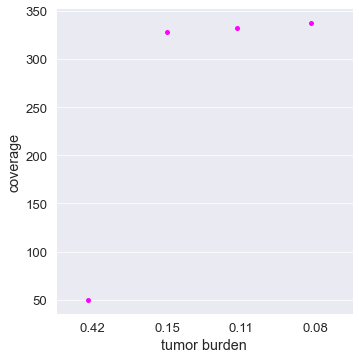

In [154]:
samples_cov = {}
for i in range(nsamples):
    ## OLD TO UPDATE
    samples_cov['sample_'+str(i)] = [float(list(pd.read_csv(os.path.join(
        "..","data", "dilutions_chr22",
        "coverage_chr22_"+plasmasample1+"_"+str(dilutionseries[i][0])+"_"+reference+"_"+str(dilutionseries[i][1])+".txt")).columns)[0]),
                                     float(list(pd.read_csv(os.path.join(
        "..","data", "dilutions_chr22",
        "estimated_tf_chr22_"+plasmasample1+"_"+str(dilutionseries[i][0])+"_"+reference+"_"+str(dilutionseries[i][1])+".txt")).columns)[0])]
print(samples_cov)


coverage_pd = pd.DataFrame.from_dict(samples_cov).T
coverage_pd.columns = ['coverage', 'tumor burden']
coverage_pd = coverage_pd.round({'tumor burden': 2}) 
sns.catplot(x='tumor burden', y='coverage', data=coverage_pd,
            order=sorted(coverage_pd['tumor burden'].unique(), reverse=True), color='magenta')
        
coverage_pd

# Number of detections detected

In [110]:
samples = list(samples_dict.values())[:nsamples]
len(samples)

4

          freebayes  mutect2  strelka2  vardict  varscan
0.418999       1093      257       395     4147     3236
0.145194       7983    15302      7927    89059    70536
0.114121       8297    15598      8136    84679    71355
0.079916       8575    15857      8321    81919    71748
          freebayes  mutect2  strelka2  vardict  varscan
0.418999        115       18        27     1794      810
0.145194        157      274        31    27513     5807
0.114121        160      272        35    25134     5722
0.079916        161      286        36    23395     5690
          freebayes  mutect2  strelka2  vardict  varscan
0.418999        369       88       120     1729      790
0.145194        137      680       160    30696    42370
0.114121        142      740       166    28730    43385
0.079916        146      826       170    27326    44050
          freebayes  mutect2  strelka2  vardict  varscan
0.418999        609      151       248      624     1636
0.145194       7689    14348   

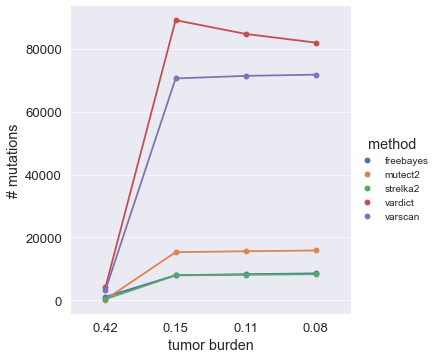

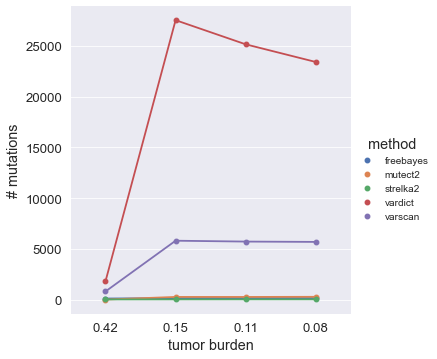

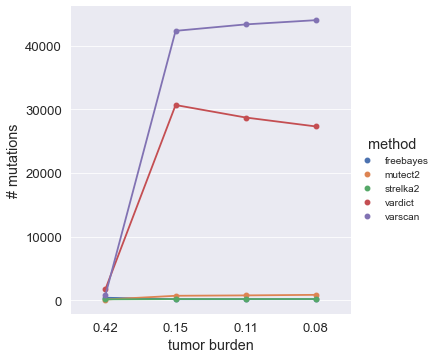

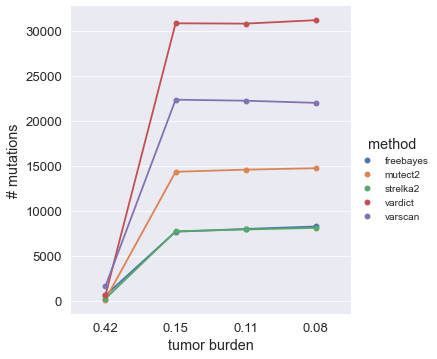

In [124]:
numbersnvs_pd = pd.DataFrame()

for mutationtype in ['all', 'INDEL', 'SNV', 'SNP']:

    for si, s in enumerate(samples):
        nb_snv = []
        for method in methods:
            if mutationtype == 'all':
                nb_snv.append(s[s[method] == True].shape[0])
            elif mutationtype == 'INDEL':
                nb_snv.append(s[(s[method] == True) & ((s['type'] == 'INS') | (s['type'] == 'DEL'))].shape[0])
            elif mutationtype == 'SNV':
                nb_snv.append(s[(s[method] == True) & (s['type'] == 'SNV')].shape[0])
            elif mutationtype == 'SNP':
                nb_snv.append(s[(s[method] == True) & (s['type'] == 'SNP')].shape[0])
            else:
                raise ValueError('mutation type {} unknown'.format(mutationtype))
        if si == 0:
            numbersnvs_pd = pd.DataFrame.from_dict({'sample_'+ str(si): nb_snv}).T
            numbersnvs_pd.columns = methods
        else:
            numbersnvs_pd.loc['sample_'+ str(si)] = nb_snv
        numbersnvs_pd = numbersnvs_pd.rename(index=samples_tf)

    numbersnvs_pd_aux = numbersnvs_pd.reset_index()
    numbersnvs_pd_aux = numbersnvs_pd_aux.rename(columns = {'index':'tumor burden'})
    numbersnvs_pd_aux = pd.melt(numbersnvs_pd_aux, id_vars=['tumor burden'], value_vars=methods, var_name='method', value_name='# mutations')
    numbersnvs_pd_aux = numbersnvs_pd_aux.rename(columns = {'index':'tumor burden'})
    numbersnvs_pd_aux = numbersnvs_pd_aux.round({'tumor burden': 2}) 
    sns.catplot(x='tumor burden', y='# mutations', kind='point', data=numbersnvs_pd_aux, hue='method',
               order=sorted(numbersnvs_pd_aux['tumor burden'].unique(), reverse=True), title=mutationtype)

    print(numbersnvs_pd)

# AUPRC with reference = SNV found in undiluted plasma sample by the same method

93656
(98476, 16)


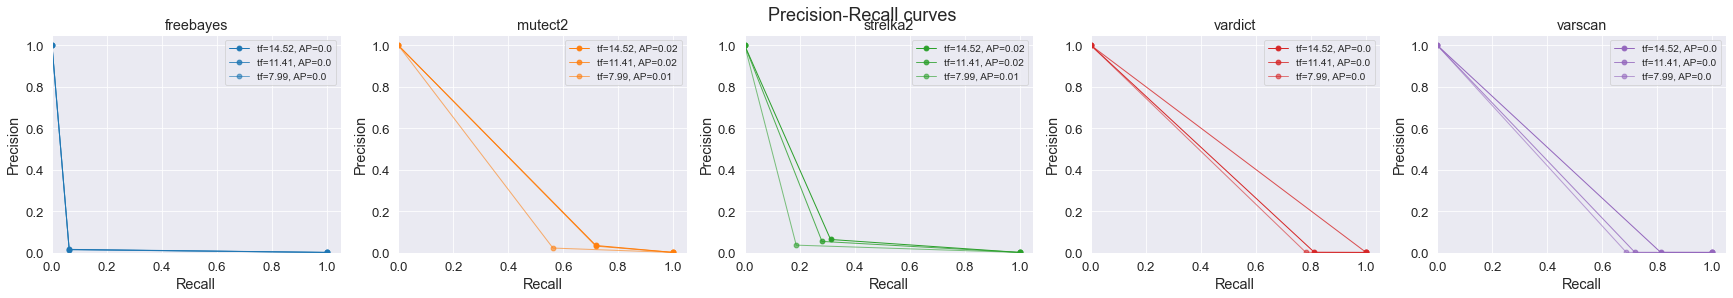

43275
(45712, 16)


<Figure size 432x288 with 0 Axes>

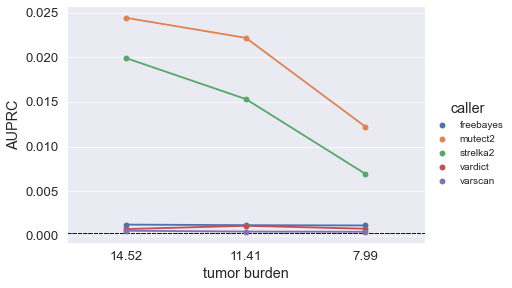

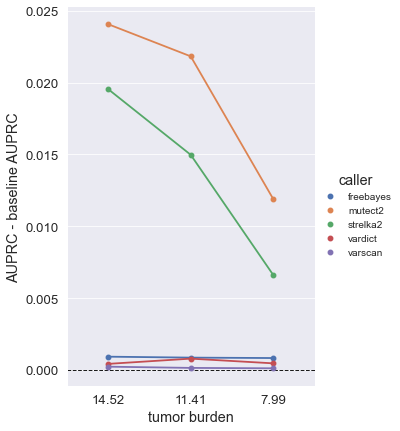

<Figure size 432x288 with 0 Axes>

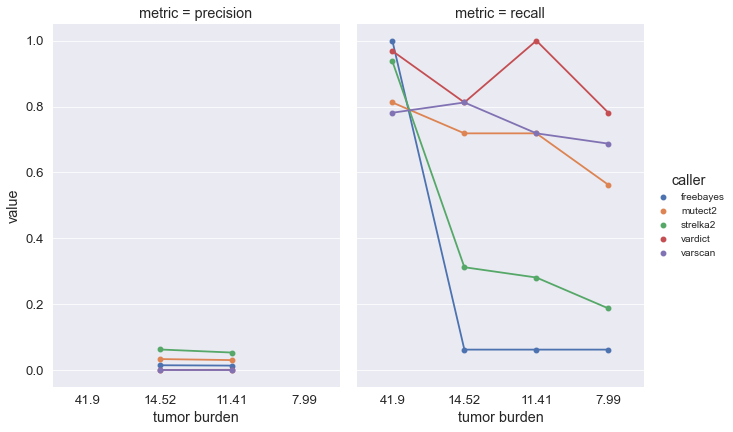

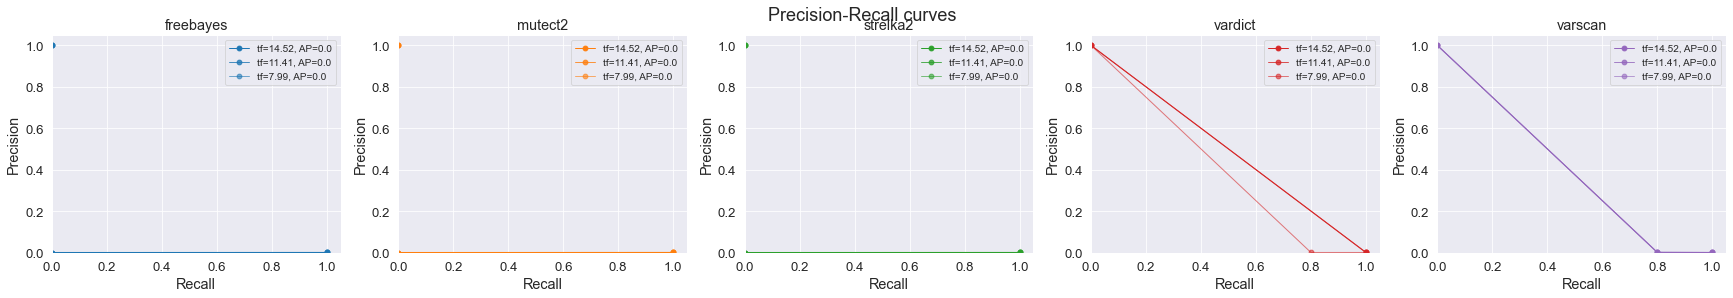

<Figure size 432x288 with 0 Axes>

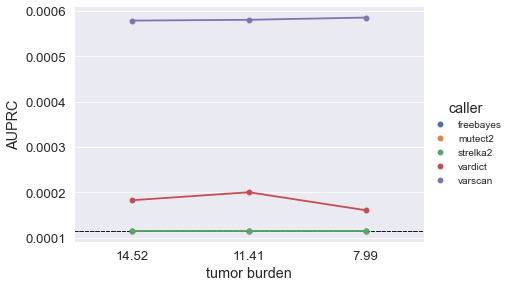

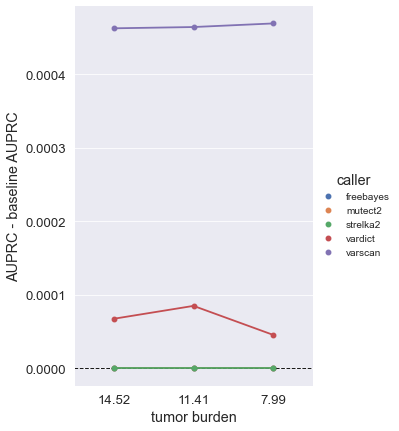

<Figure size 432x288 with 0 Axes>

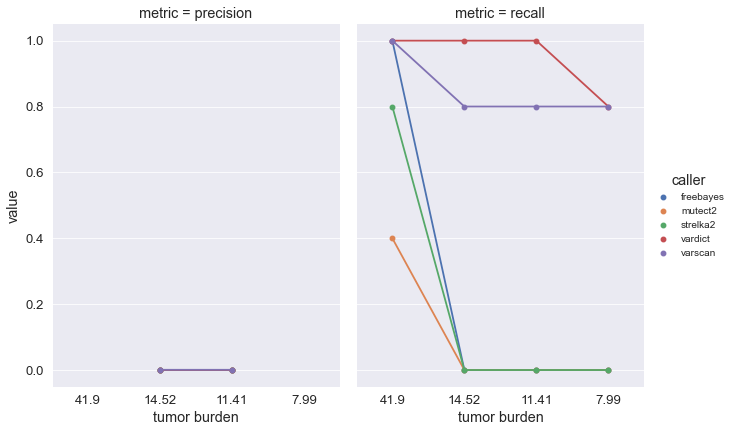

In [200]:
for mutation in ['snv', 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_0', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_0'].sum()
    y_true[y_true <= 3] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])
    print(pd_methods.shape)

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
       # y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples-1], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=4, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    #plt.ylim([0.1, 0.5])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    #plt.ylim([0, 0.5])

# AUPRC with reference = SNV found in both undiluted plasma samples by the same method

In [ ]:
for mutation in ['snv', 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            if i == 0:
                si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            else:
                si = sample[['QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]] = pd_method[list(samples_dict.keys())[:nsamples]].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)]].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_0', 'sample_0_bis', 'caller']]
    y_true['ref'] = pd_methods['sample_0'] & pd_methods['sample_0_bis']
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['ref'].sum()
    y_true = y_true.astype(bool)

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
       # y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples-1], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=4, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    #plt.ylim([0.1, 0.5])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    #plt.ylim([0, 0.5])

## AUPRC with reference = SNV found in the tumor by the same method

93656


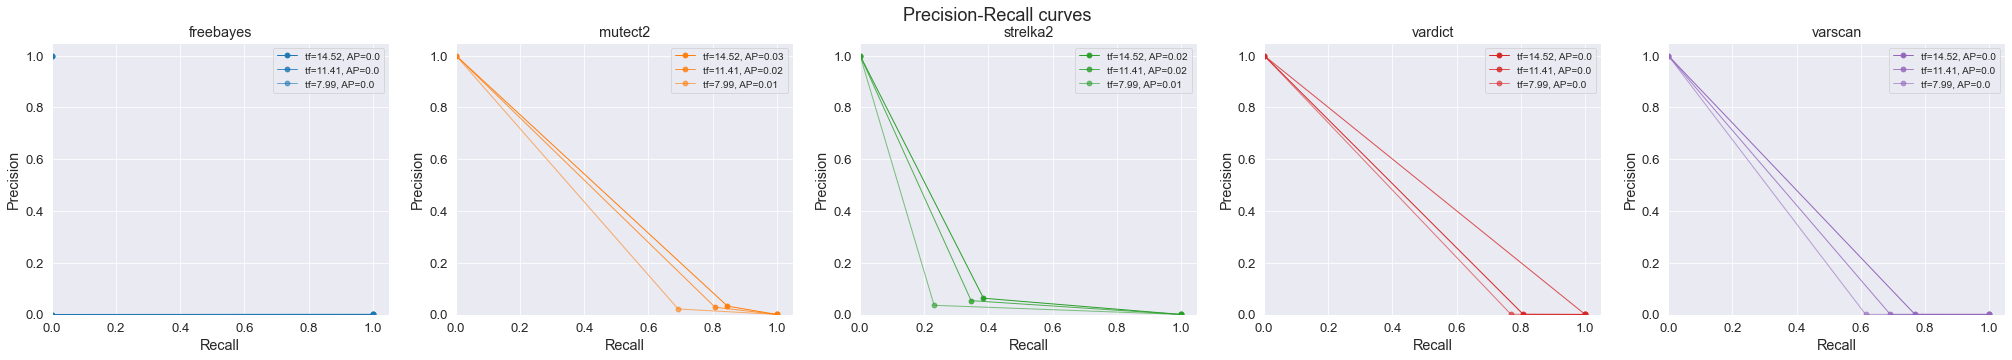

43275


<Figure size 432x288 with 0 Axes>

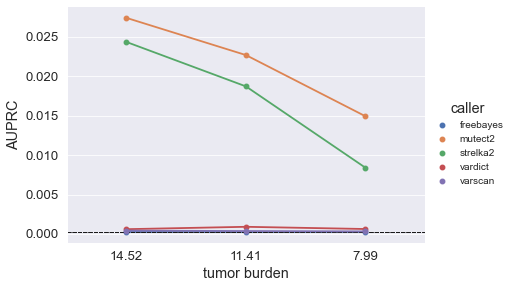

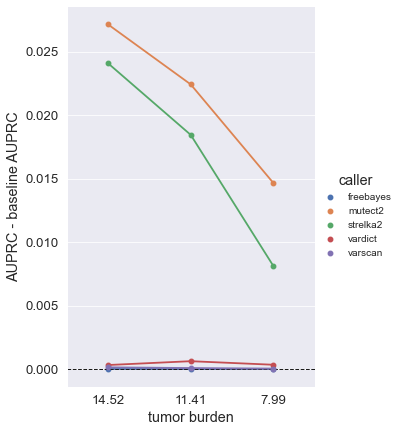

<Figure size 432x288 with 0 Axes>

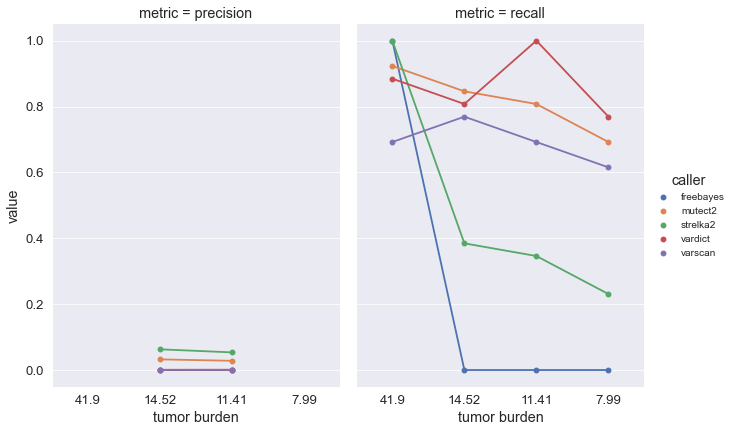

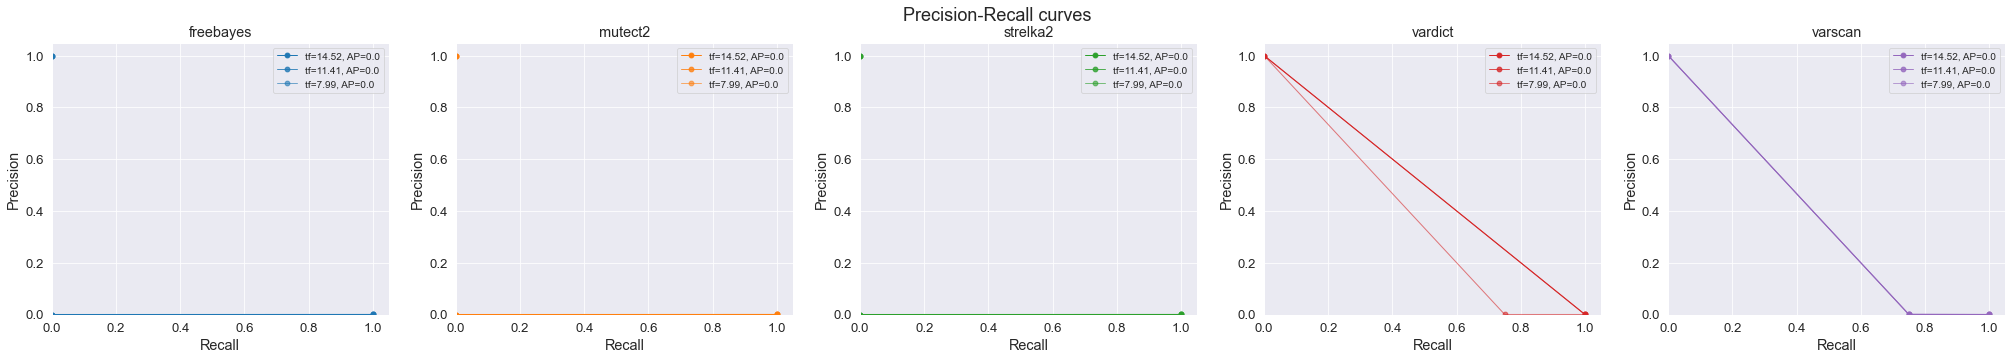

<Figure size 432x288 with 0 Axes>

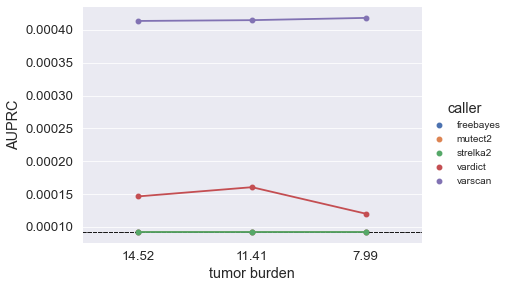

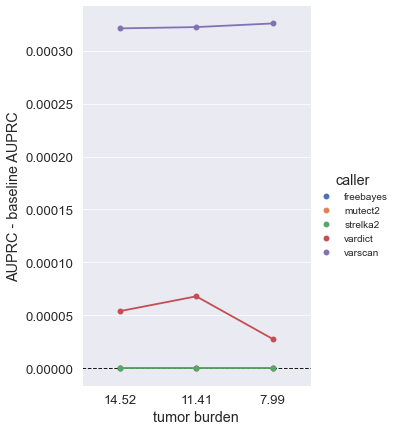

<Figure size 432x288 with 0 Axes>

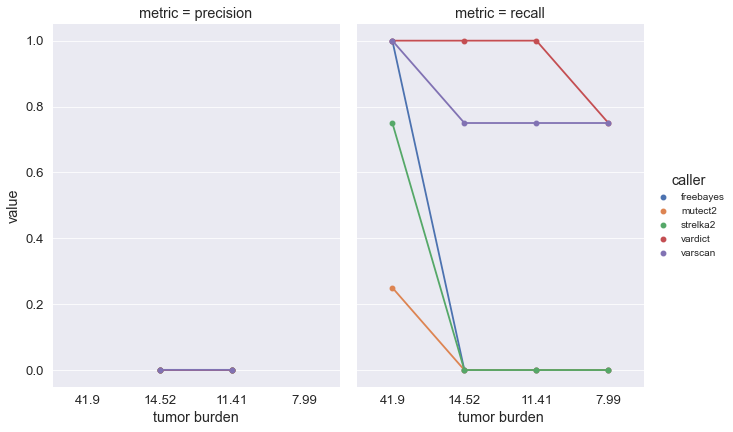

In [207]:
for mutation in ['snv', 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(methods):
        
        slist = []

        for i, sample in enumerate(samples):
            si = sample[['REF', 'ALT', 'QUAL', 'type', method]]
            si.rename(columns = {method:'sample_'+str(i)},  inplace = True)
            slist.append(si)
        st = samples_dict['sample_t'][['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        slist.append(st)

        pd_method = pd.concat([si.loc[~si.index.duplicated()] for si in slist], axis=1)
        
        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T

        aux = []
        for i in range(nsamples):
            aux.append('QUAL_'+str(i))
            aux.append('type_'+str(i))
            aux.append('sample_'+str(i))
        aux = aux + ['QUAL_t', 'type_t', 'sample_t']
        pd_method.columns = ['REF', 'ALT'] + aux
        pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']] = pd_method[list(samples_dict.keys())[:nsamples]+['sample_t']].fillna(value=False)
        pd_method.drop(pd_method[sum(pd_method['sample_'+str(i)] for i in range(nsamples)) == False].index, axis=0, inplace=True)
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_'+str(i) for i in range(nsamples)] +['type_t']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]
                                
        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame
    pd_results_PR = pd.DataFrame
    count = 0

    fig, axs = plt.subplots(1,nmethods,figsize=(35, 5))
    fig.suptitle('Precision-Recall curves')
    
    y_true = pd_methods[['sample_t', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_t'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])

    baselineAUPRC = {}


    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        y_list = []
       # y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)
        for i in range(nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            y_list.append(y_i)

        res_df['AUPRC'] = [average_precision_score(y_true, y_i) for y_i in y_list]  
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_i) - baselineAUPRC[method] for y_i in y_list]
        res_PR_df['precision'] = [precision_score(y_true, y_i) for y_i in y_list]
        res_PR_df['recall'] = [recall_score(y_true, y_i) for y_i in y_list]

        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method

        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, nsamples-1], inplace=True)

        
        # Plot Precision-Recall curve
        for i in range(1,nsamples):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    plt.figure()
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=4, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    #plt.ylim([0.1, 0.5])
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    plt.figure()
    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results_PR['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    #plt.ylim([0, 0.5])

6000


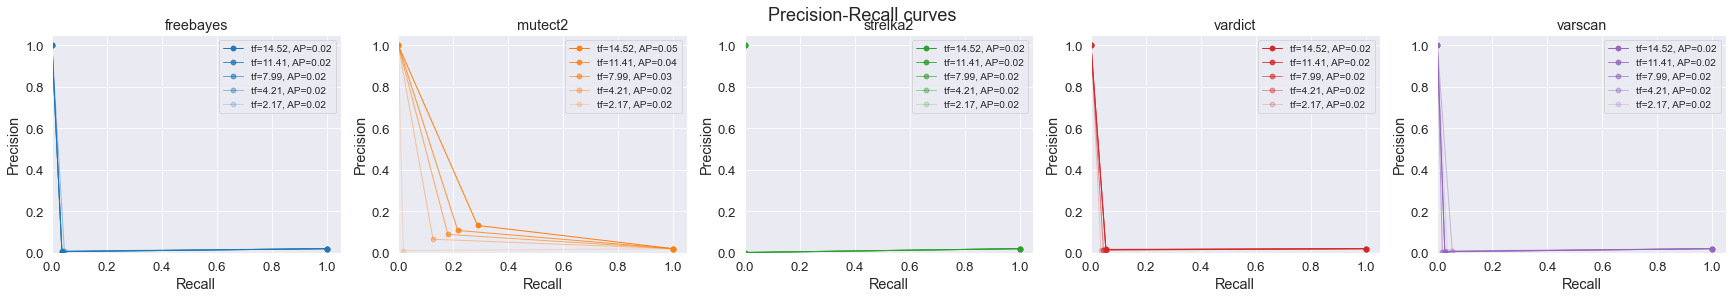

5287


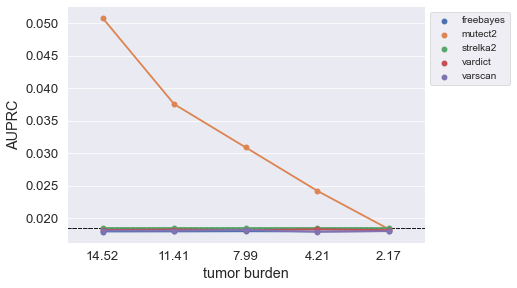

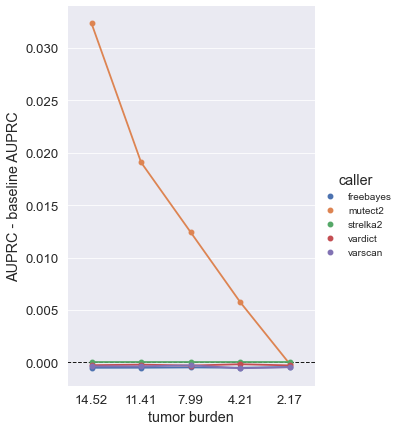

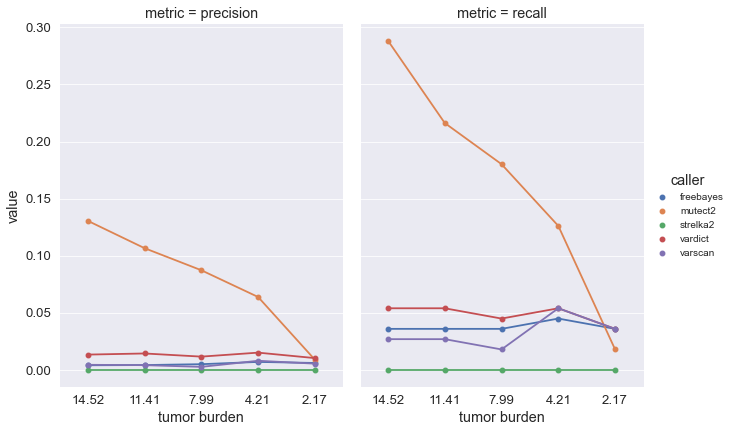

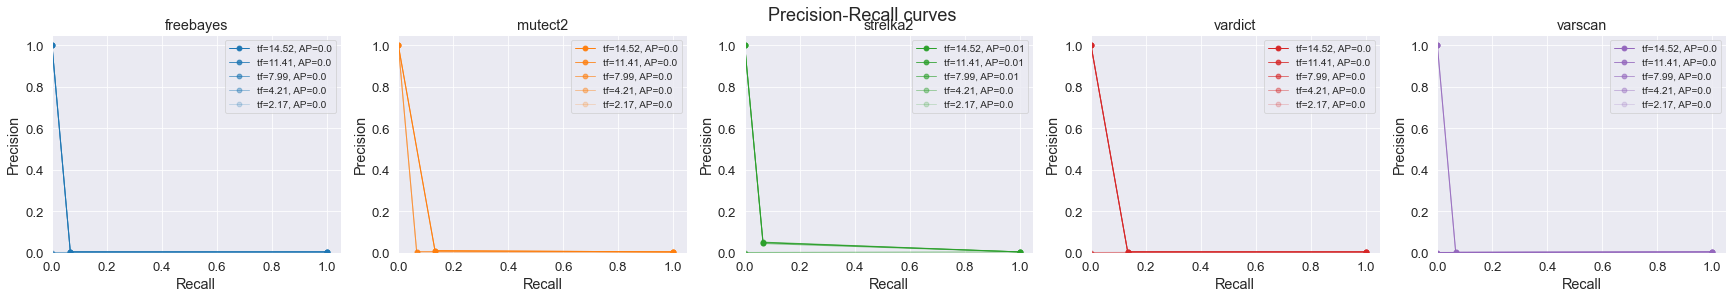

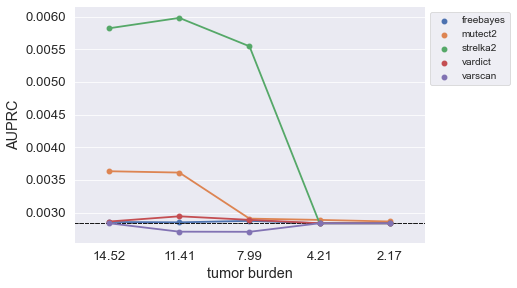

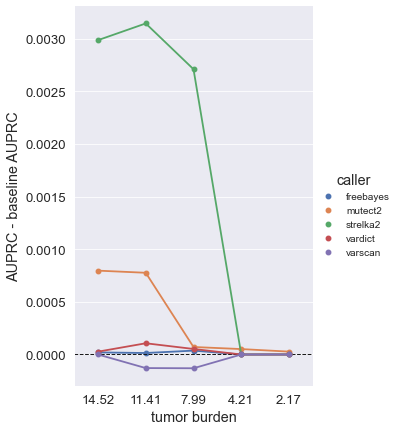

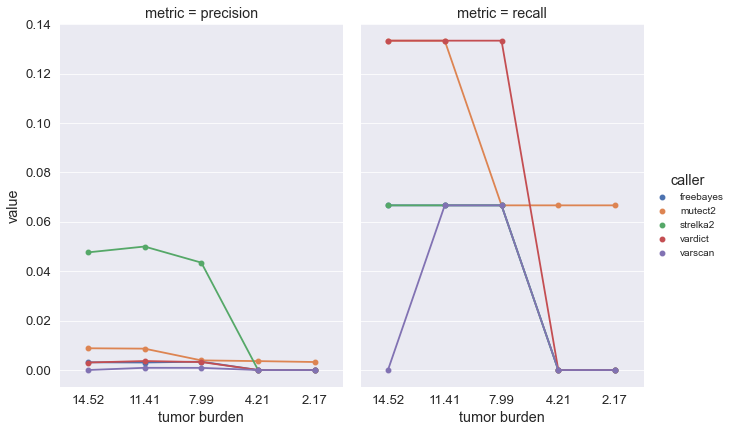

In [38]:
for mutation in ['snv', 'indel']:
    pd_methods = pd.DataFrame
    count = 0

    for mi, method in enumerate(['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']):

        s0 = sample_0[['REF', 'ALT', 'QUAL', 'type', method]]
        s0.rename(columns = {method:'sample_0'},  inplace = True)
        st = sample_t[['REF', 'ALT', 'QUAL', 'type', method]]
        st.rename(columns = {method:'sample_t'},  inplace = True)
        s1 = sample_1[['REF', 'ALT', 'QUAL', 'type', method]]
        s1.rename(columns = {method:'sample_1'},  inplace = True)
        s2 = sample_2[['REF', 'ALT', 'QUAL', 'type', method]]
        s2.rename(columns = {method:'sample_2'},  inplace = True)
        s3 = sample_3[['REF', 'ALT', 'QUAL', 'type', method]]
        s3.rename(columns = {method:'sample_3'},  inplace = True)
        #s4 = sample_4[['REF', 'ALT', 'QUAL','type', method]]
        #s4.rename(columns = {method:'sample_4'},  inplace = True)
        #s5 = sample_5[['REF', 'ALT', 'QUAL','type', method]]
        #s5.rename(columns = {method:'sample_5'},  inplace = True)

        pd_method = pd.concat([s0.loc[~s0.index.duplicated()],
               st.loc[~st.index.duplicated()],
               s1.loc[~s1.index.duplicated()],
               s2.loc[~s2.index.duplicated()],
               s3.loc[~s3.index.duplicated()],
               s4.loc[~s4.index.duplicated()],
               s5.loc[~s5.index.duplicated()]], axis=1)

        pd_method['REF'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['REF'].values)]
        pd_method['ALT'] = [list(np.unique([i for i in list(ai) if str(i) != 'nan']))[-1] for ai in list(pd_method['ALT'].values)]
        pd_method = pd_method.T.drop_duplicates().T
        pd_method.columns = ['REF', 'ALT', 'QUAL_0', 'type_0', 'sample_0','QUAL_t', 'type_t', 'sample_t', 'QUAL_1', 'type_1', 'sample_1', 'QUAL_2', 'type_2', 'sample_2',  'QUAL_3', 'type_3', 'sample_3', 'QUAL_4', 'type_4', 'sample_4', 'QUAL_5', 'type_5', 'sample_5']
        pd_method[['sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']] = pd_method[['sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']].fillna(value=False)
        #pd_method.drop(pd_method[pd_method['sample_0'] + pd_method['sample_0_bis']+ pd_method['sample_1'] + pd_method['sample_2'] + pd_method['sample_3'] + pd_method['sample_4'] == False].index, axis=0, inplace=True)
        pd_method[['REF', 'sample_0', 'sample_t', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5']].head()
        pd_method['caller'] = method
        pd_method['type'] = pd_method[['type_0','type_t','type_1', 'type_2', 'type_3', 'type_4', 'type_5']].fillna('').sum(axis=1).apply(lambda x: pd.Series(x[:3]))

        if mutation == 'snv':
            pd_method = pd_method[pd_method['type'] == 'SNV']
        elif mutation == 'indel':
            pd_method = pd_method[(pd_method['type'] == 'INS') | (pd_method['type'] == 'DEL')]

        if count == 0:
            pd_methods = pd_method
            count = 1
        else:
            pd_methods = pd.concat([pd_methods, pd_method], join='inner')

    pd_results = pd.DataFrame.empty
    pd_results_PR = pd.DataFrame.empty
    count = 0

    fig, axs = plt.subplots(1,5,figsize=(30, 4))
    fig.suptitle('Precision-Recall curves')


    y_true = pd_methods[['sample_t', 'caller']]
    y_true.index.name = 'CHROM_POS'
    y_true = y_true.groupby(['CHROM_POS'])['sample_t'].sum()
    y_true[y_true <= 2] = 0
    y_true = y_true.astype(bool)
    print(y_true.shape[0])



    baselineAUPRC = {}

    for mi, method in enumerate(methods):

        res_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')
        res_PR_df = (100*pd.Series(samples_tf)).round(decimals=2).to_frame(name='tumor burden')

        #y_true = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool) + pd_methods[pd_methods['caller'] == method]['sample_0_bis'].astype(bool)
        baselineAUPRC[method] = len(y_true[y_true == True])/len(y_true)

        y_0 = pd_methods[pd_methods['caller'] == method]['sample_0'].astype(bool).reindex(y_true.index).squeeze()
        y_0 = y_0.fillna(False)
        y_1 = pd_methods[pd_methods['caller'] == method]['sample_1'].astype(bool).reindex(y_true.index).squeeze()
        y_1 = y_1.fillna(False)
        y_2 = pd_methods[pd_methods['caller'] == method]['sample_2'].astype(bool).reindex(y_true.index).squeeze()
        y_2 = y_2.fillna(False)
        y_3 = pd_methods[pd_methods['caller'] == method]['sample_3'].astype(bool).reindex(y_true.index).squeeze()
        y_3 = y_3.fillna(False)
        y_4 = pd_methods[pd_methods['caller'] == method]['sample_4'].astype(bool).reindex(y_true.index).squeeze()
        y_4 = y_4.fillna(False)
        y_5 = pd_methods[pd_methods['caller'] == method]['sample_5'].astype(bool).reindex(y_true.index).squeeze()
        y_5 = y_5.fillna(False)

        res_df['AUPRC'] = [average_precision_score(y_true, y_0),
                          average_precision_score(y_true, y_1),
                          average_precision_score(y_true, y_2),
                          average_precision_score(y_true, y_3),
                          average_precision_score(y_true, y_4),
                          average_precision_score(y_true, y_5),
                         ]
        res_df['AUPRC - baseline AUPRC'] = [average_precision_score(y_true, y_0) - baselineAUPRC[method],
                      average_precision_score(y_true, y_1) - baselineAUPRC[method],
                      average_precision_score(y_true, y_2) - baselineAUPRC[method],
                      average_precision_score(y_true, y_3) - baselineAUPRC[method],
                      average_precision_score(y_true, y_4) - baselineAUPRC[method],
                      average_precision_score(y_true, y_5) - baselineAUPRC[method],

                     ]
        res_PR_df['precision'] = [precision_score(y_true, y_0),
                          precision_score(y_true, y_1),
                          precision_score(y_true, y_2),
                          precision_score(y_true, y_3),
                          precision_score(y_true, y_4),
                          precision_score(y_true, y_5),
                         ]

        res_PR_df['recall'] = [recall_score(y_true, y_0),
                          recall_score(y_true, y_1),
                          recall_score(y_true, y_2),
                          recall_score(y_true, y_3),
                          recall_score(y_true, y_4),
                          recall_score(y_true, y_5),
                         ]
        res_PR_df = pd.melt(res_PR_df, id_vars =['tumor burden'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
        res_df['caller'] = method
        res_PR_df['caller'] = method
        res_df.drop(['sample_0'], inplace=True)
        res_PR_df.drop([0, 6], inplace=True)

        # Plot Precision-Recall curve
        alpha_list = [0, 1, .8, .6, .4, .2, .1]
        for i in range(1,6):
            y_i = pd_methods[pd_methods['caller'] == method]['sample_'+str(i)].astype(bool).reindex(y_true.index).squeeze()
            y_i = y_i.fillna(False)
            precision, recall, _ = precision_recall_curve(y_true, y_i)
            axs[mi].plot(recall, precision, 'o-',
                                  label='tf='+str(res_df['tumor burden'].loc['sample_'+str(i)])+ ', AP='+str(round(average_precision_score(y_true, y_i), 2)),
                                  c=color_list[mi], alpha=alpha_list[i])
        axs[mi].set_xlabel('Recall')
        axs[mi].set_ylabel('Precision')
        axs[mi].set_ylim([0.0, 1.05])
        axs[mi].set_xlim([0.0, 1.05])
        axs[mi].set_title(method)
        axs[mi].legend()

        if count == 0:
            pd_results = res_df
            pd_results_PR = res_PR_df
            count = 1
        else:
            pd_results = pd.concat([pd_results, res_df], join='inner')
            pd_results_PR = pd.concat([pd_results_PR, res_PR_df], join='inner')
    plt.show()

    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                    capsize=.2, height=4, aspect=1.5,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results, legend=False)
    for mi, method in enumerate(methods):
        plt.axhline(y = baselineAUPRC[method], color = lc, linestyle = '--') 
    #plt.ylim([0, 0.5])
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    
    sns.catplot(x="tumor burden", y="AUPRC - baseline AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75,
                kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results)
    plt.axhline(y = 0, color = lc, linestyle = '--', label='baseline AUPRC') 

    sns.catplot(x="tumor burden", y="value", col="metric", hue="caller",  
                    capsize=.2, height=6, aspect=.75,
                    kind="point", order=sorted(pd_results['tumor burden'].unique(), reverse=True), data=pd_results_PR)
    #plt.ylim([0, 0.5])

- Histograms of true allele frequencies in each tumor sample. Note how increasing admixture increases the prevalence of low- frequency variants.
- Benchmarking results for germline SNVs
- Benchmarking results for somatic SNVs on exome data.
- averaged over the four replicates

- add fake mutations on healthy mixtures